In [1]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer, execute, transpile, assemble
from qiskit.circuit import Parameter,ParameterVector
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import EfficientSU2, ZZFeatureMap
from qiskit.opflow import Z, X, I, StateFn, CircuitStateFn, SummedOp
from qiskit.opflow.gradients import Gradient, NaturalGradient, QFI, Hessian
from qiskit_machine_learning.circuit.library import RawFeatureVector
from sklearn.preprocessing import OneHotEncoder
from qiskit.algorithms.optimizers import SPSA, GradientDescent, QNSPSA
import numpy as np
import itertools as itr
import matplotlib.pyplot as plt

DIR_val_train = "Encode_data/ang_enc_data_set_trainning_values.csv"
DIR_cls_train = "Encode_data/ang_enc_data_set_trainning_classes.csv"

DIR_val_test = "Encode_data/ang_enc_data_set_test_values.csv"
DIR_cls_test = "Encode_data/ang_enc_data_set_test_classes.csv"

# Circuito

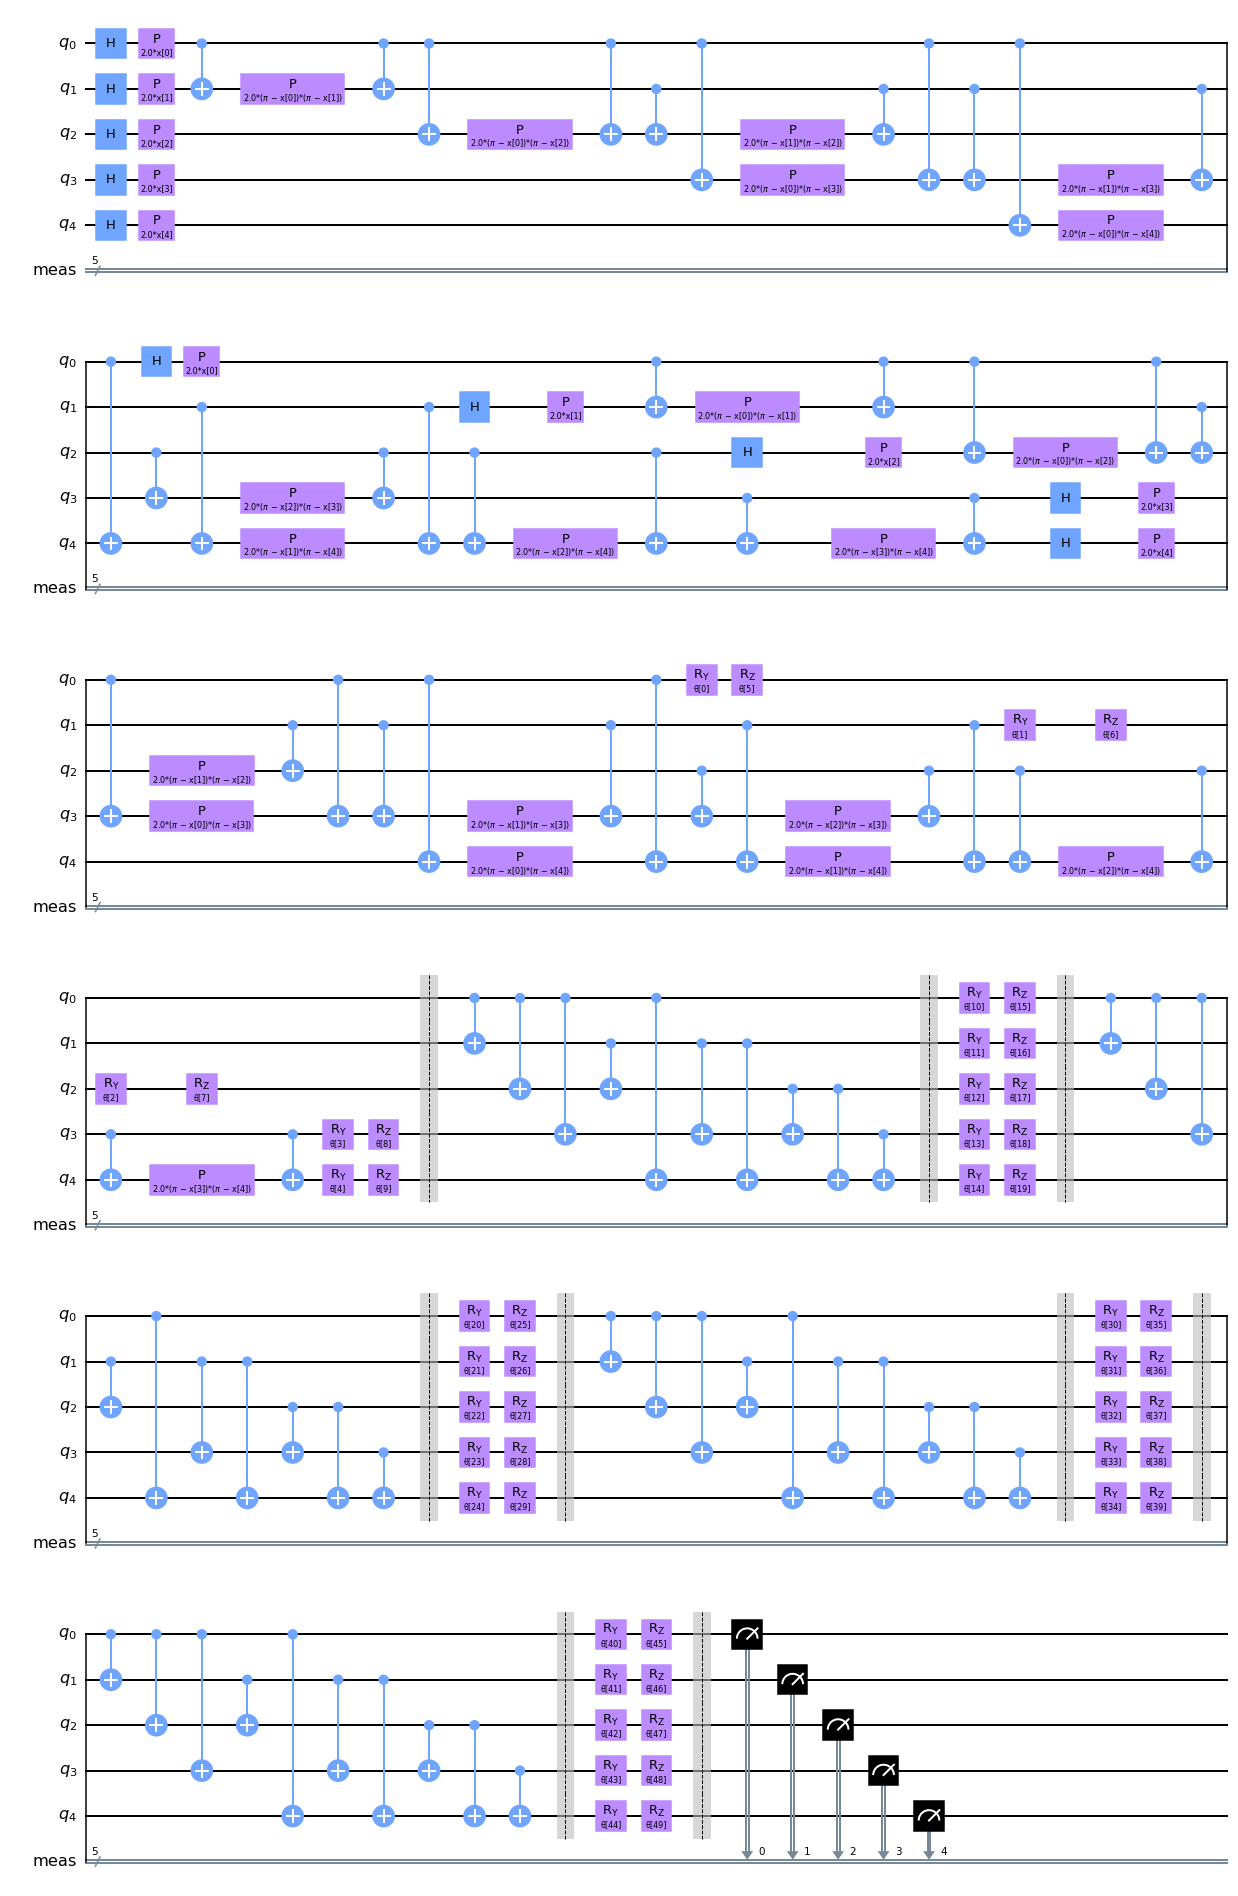

In [2]:
n_qubits = 5

encoding = ZZFeatureMap(feature_dimension=n_qubits, reps=2)

ansatz = EfficientSU2(n_qubits, entanglement='full', reps=4, 
                        insert_barriers=True, name="U(\u03B8)", 
                        parameter_prefix="\u03B8")
qc = encoding.compose(ansatz)
qc.measure_all()
qc.decompose().draw(output="mpl")

In [3]:
train_data = np.genfromtxt(DIR_val_train, delimiter=";")
train_labels = np.genfromtxt(DIR_cls_train, delimiter=";")

test_data = np.genfromtxt(DIR_val_test, delimiter=";")
test_labels = np.genfromtxt(DIR_cls_test, delimiter=";")

In [4]:
def circuit_parameters(encoding, ansatz, x, thetas, self_encoding=False):
    parameters = {}
    if self_encoding:
        for i, p in enumerate(list(encoding.parameters)):
            parameters[p] = x[i]
    else:
        for i, p in enumerate(list(encoding.ordered_parameters)):
            parameters[p] = x[i]
    for i, p in enumerate(ansatz.ordered_parameters):
        parameters[p] = thetas[i]
    return parameters

In [5]:

def train(qc, encoding, ansatz, train_data, train_labels, self_encoding=False, lr=None, initial_point=None):
        # Callback function for optimiser for plotting purposes
        def store_intermediate_result(evaluation, parameter, cost, 
                                stepsize, accept):
                evaluations.append(evaluation)
                parameters.append(parameter)
                costs.append(cost)

        # Set up the optimization

        parameters = []
        costs = []
        evaluations = []

        if lr is not None:
                optimizer = SPSA(maxiter=200 , learning_rate=lr, perturbation=0.01, callback=store_intermediate_result)
        else:
                optimizer = SPSA(maxiter=200, callback=store_intermediate_result)

        if initial_point is not None:
                initial_point = initial_point
        else:      
                initial_point = np.random.random(ansatz.num_parameters)

        objective_function = lambda variational: cost_function(qc,encoding, ansatz,
                train_data, train_labels, variational, self_encoding=self_encoding)
        
        # Run the optimization
        opt_var, opt_value, _ = optimizer.optimize(len(initial_point), objective_function, initial_point=initial_point)

        return opt_var, opt_value , parameters, costs, evaluations 

## Mean Square error

### Multi Qubit exp val

$$Cost() = \frac{1}{N}\sum (y-\hat{y})^2$$


In [6]:
train_labels_oh = train_labels
test_labels_oh = test_labels

In [7]:
def cost_function(qc, encoding, ansatz, X, Y, thetas, self_encoding=False):
    #thetas -> variational parameters
    #X dataset
    #Y labels

    #build circuits for each datapoint
    circuits = [qc.assign_parameters(circuit_parameters(encoding, ansatz, x, thetas, self_encoding=self_encoding)) for x in X]
    
    backend = Aer.get_backend('qasm_simulator')
    results =  execute(circuits, backend).result()

    predictions = [classification(results.get_counts(c)) for c in circuits]
    #print(predictions)
    cost = np.mean(np.array([loss_function(y,y_hat) for (y,y_hat) in zip(Y, predictions)]))
    print(f"Cost {cost}")
    return cost

In [8]:
#%%script echo skipping
def basis_states_probs(counts, shots=1024, decimal=False, n_qubits=1):
    
    """
    Retorna as probabilidades de cada estado
    """
    
    probs = []
   
    if decimal:
        basis_states = list(range(2**n_qubits))
    else:
        basis_states = [np.binary_repr(i,width=n_qubits) for i in range(2**n_qubits)]

    for b in basis_states:
        c = counts.get(b)
        if c is None:
            probs.append(0)
        else:
            probs.append(counts[b]/shots)
    
    return probs


def classification(counts, shots=1024, label=True):
    
    def count_ones(string):
        r = 0
        for char in string:
            if char == "1":
                r+=1
        return r
    
    def label_assign(exp_val):
        if exp_val >= 0:
            r = 1
        else:
            r = -1
        return r

    probs = basis_states_probs(counts, n_qubits=n_qubits)
    states = ["".join(seq) for seq in itr.product("01", repeat=n_qubits)]
    
    exp_val = 0
    for state, prob in zip(states, probs):
        #print(prob, state)
        exp_val += ((-1)**(count_ones(state)%2))*prob
    
    #print(f"Valor expectávlel {exp_val}, Label {label_assign(exp_val)} ")
    if label:
        return label_assign(exp_val)
    else:
        return exp_val
    
def loss_function(y,y_hat):
    #print(f"Loss {y}-{y_hat}**2")
    #print(f"Loss {(y-y_hat)**2}")
    return (y-y_hat) * (y-y_hat)

In [9]:
opt_var, opt_value , parameters, costs, evaluations = train(qc, encoding, ansatz, train_data, train_labels_oh, self_encoding=True)

Cost 1.85
Cost 1.95
Cost 1.9
Cost 1.85
Cost 1.8
Cost 1.7
Cost 2.2
Cost 1.9
Cost 1.75
Cost 2.25
Cost 1.5
Cost 1.85
Cost 1.8
Cost 1.55
Cost 1.75
Cost 2.05
Cost 1.45
Cost 1.95
Cost 2.1
Cost 1.7
Cost 1.8
Cost 2.0
Cost 1.75
Cost 2.2
Cost 1.75
Cost 2.05
Cost 2.0
Cost 1.7
Cost 2.2
Cost 1.9
Cost 1.85
Cost 2.05
Cost 2.2
Cost 1.65
Cost 1.5
Cost 1.85
Cost 1.7
Cost 1.6
Cost 1.6
Cost 2.15
Cost 1.8
Cost 1.85
Cost 1.8
Cost 2.25
Cost 1.4
Cost 2.0
Cost 2.2
Cost 2.2
Cost 1.65
Cost 1.75
Cost 1.85
Cost 1.95
Cost 1.75
Cost 1.55
Cost 2.2
Cost 1.9
Cost 2.15
Cost 2.1
Cost 2.0
Cost 1.7
Cost 2.0
Cost 2.0
Cost 2.2
Cost 1.9
Cost 2.05
Cost 1.65
Cost 2.2
Cost 2.05
Cost 2.1
Cost 1.6
Cost 1.4
Cost 2.1
Cost 1.15
Cost 1.95
Cost 2.5
Cost 1.75
Cost 1.7
Cost 2.1
Cost 1.45
Cost 1.75
Cost 1.8
Cost 1.75
Cost 1.85
Cost 1.7
Cost 2.05
Cost 1.5
Cost 1.6
Cost 1.55
Cost 1.7
Cost 1.75
Cost 1.85
Cost 1.75
Cost 1.55
Cost 1.5
Cost 1.7
Cost 1.85
Cost 1.55
Cost 1.7
Cost 1.35
Cost 1.9
Cost 1.65
Cost 1.6
Cost 1.45
Cost 1.7
Cost 1.5
Cost 2

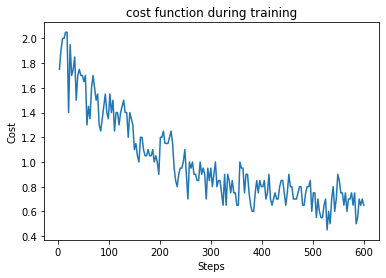

In [10]:
fig = plt.figure()
plt.plot(evaluations, costs)
plt.xlabel("Steps")
plt.ylabel("Cost")
plt.title("cost function during training")
plt.show()

In [11]:
def func_accuracy(data, labels, thetas, self_encoding=False):
    circuits = [qc.assign_parameters(circuit_parameters(encoding, ansatz, x, thetas, self_encoding=self_encoding)) for x in data]
    #print(circuits)

    backend = Aer.get_backend('qasm_simulator')
    results =  execute(circuits, backend).result()

    prediction = [classification(results.get_counts(c)) for c in circuits]
    print(f"Predictions: {prediction}")
    print(f"Labels: {labels}")
    #prediction = [0 if p[0] > p[1] else 1 for p in probs]
    accuracy = 0
    for i, p in enumerate(prediction):
        #if (p and labels[i]) or (not p and not labels[i]):
        if p == labels[i]:
            accuracy += 1
    accuracy /= len(labels)
    return accuracy, prediction

In [12]:
accuracy, prediction = func_accuracy(test_data, test_labels, opt_var, self_encoding=True)
print("Test set accuracy - {}".format(accuracy))

Predictions: [-1, 1, -1, 1, -1, 1, -1, -1, -1, 1, -1, 1, -1, -1, 1, 1, 1, 1, -1, 1, -1, -1, 1, 1]
Labels: [-1. -1.  1. -1.  1. -1.  1. -1. -1.  1. -1.  1.  1. -1.  1.  1.  1.  1.
 -1. -1. -1. -1.  1.  1.]
Test set accuracy - 0.6666666666666666


## Cross Entropy Loss

### Parity method

In [13]:
encoder = OneHotEncoder()
train_labels_oh = encoder.fit_transform(train_labels.reshape(-1, 1)).toarray()
test_labels_oh = encoder.fit_transform(test_labels.reshape(-1, 1)).toarray()

In [14]:
def parity_classification(counts, shots=1024):
    probs = np.zeros(2)
    for bitstring, counts in counts.items():
        hw_parity = hamming_weight_parity(bitstring)
        probs[hw_parity] += counts/shots
    
    return probs
def hamming_weight_parity(bitstring):
    hamming_weight = sum([int(k) for k in bitstring])
    return hamming_weight % 2

def loss_function(y,y_hat):
    #print(y_hat)
    return np.sum(y*np.log(y_hat))

In [15]:
def cost_function(qc, encoding, ansatz, X, Y, thetas, self_encoding=False):
    #thetas -> variational parameters
    #X dataset
    #Y labels

    #build circuits for each datapoint
    circuits = [qc.assign_parameters(circuit_parameters(encoding, ansatz, x, thetas, self_encoding=self_encoding)) for x in X]

    backend = Aer.get_backend('qasm_simulator')
    results =  execute(circuits, backend).result()

    predictions = [parity_classification(results.get_counts(c)) for c in circuits]

    cost = -np.mean(np.array([loss_function(y,y_hat) for (y,y_hat) in zip(Y, predictions)]))
    print(f"Cost: {cost}")
    
    return cost

In [16]:
opt_var, opt_value , parameters, costs, evaluations = train(qc, encoding, ansatz, train_data, train_labels_oh, self_encoding=True)

Cost: 0.6750585083655063
Cost: 0.6852508656408681
Cost: 0.7041081079815189
Cost: 0.6959189386399824
Cost: 0.6874748055523631
Cost: 0.7184749671644817
Cost: 0.6897043567477056
Cost: 0.673920493448714
Cost: 0.700657902643394
Cost: 0.6842040164643536
Cost: 0.7433121176182451
Cost: 0.7046483010791749
Cost: 0.7005210719888048
Cost: 0.6737632983512677
Cost: 0.7452230594624951
Cost: 0.6744369448150666
Cost: 0.7000571787739478
Cost: 0.7084107562661093
Cost: 0.6990267789388018
Cost: 0.6718874054638241
Cost: 0.7197347906654453
Cost: 0.690292802887053
Cost: 0.7052686335688015
Cost: 0.6728933696557815
Cost: 0.7052741509014258
Cost: 0.7145630571751331
Cost: 0.6903356458518205
Cost: 0.6909184668125892
Cost: 0.6543404395746711
Cost: 0.7156274664055251
Cost: 0.7397996495968041
Cost: 0.7336781189069768
Cost: 0.675719047435105
Cost: 0.7377655883473885
Cost: 0.7024281428926393
Cost: 0.6662836122109579
Cost: 0.6826328753706971
Cost: 0.7051913037757842
Cost: 0.7259007308465483
Cost: 0.7060214060354797
Cost

Cost: 0.5464236505115014
Cost: 0.5015319152889698
Cost: 0.5077108054547212
Cost: 0.5516217896481502
Cost: 0.5035550274171801
Cost: 0.5077082819123062
Cost: 0.5453419597512108
Cost: 0.5019085793756812
Cost: 0.5236651052836739
Cost: 0.5058816740404535
Cost: 0.5022674868920223
Cost: 0.5396480368193026
Cost: 0.4970069120290302
Cost: 0.4927281602676624
Cost: 0.5207429693412001
Cost: 0.5112781139162434
Cost: 0.49651910880428884
Cost: 0.516056915371899
Cost: 0.5245776228950069
Cost: 0.4907909702641814
Cost: 0.5195962958059146
Cost: 0.5145530692378182
Cost: 0.4974475953431047
Cost: 0.513398125062278
Cost: 0.5228097038555811
Cost: 0.49006964907823436
Cost: 0.5218039569086135
Cost: 0.5031706124470392
Cost: 0.4965568823525889
Cost: 0.5136788872934195
Cost: 0.5156828654599072
Cost: 0.4929056254192977
Cost: 0.5403134981034334
Cost: 0.49331833254971513
Cost: 0.4928485860285968
Cost: 0.5140118436484119
Cost: 0.4924954393942656
Cost: 0.4920241845449061
Cost: 0.5067409751246866
Cost: 0.5041886929138885

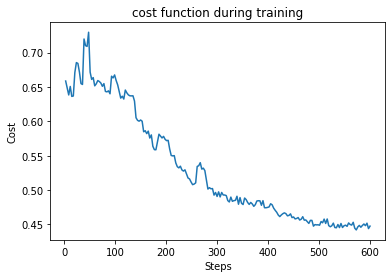

In [17]:
fig = plt.figure()
plt.plot(evaluations, costs)
plt.xlabel("Steps")
plt.ylabel("Cost")
plt.title("cost function during training")
plt.show()

In [18]:
def func_accuracy(data, labels, thetas, self_encoding=False):
    circuits = [qc.assign_parameters(circuit_parameters(encoding, ansatz, x, thetas, self_encoding=self_encoding)) for x in data]

    backend = Aer.get_backend('qasm_simulator')
    results =  execute(circuits, backend).result()

    probs = [parity_classification(results.get_counts(c)) for c in circuits]
    prediction = [-1 if p[0] > p[1] else 1 for p in probs]
    accuracy = 0
    print(prediction)
    print(labels)
    for i, p in enumerate(prediction):
        if p == labels[i]:
            accuracy += 1
    accuracy /= len(labels)
    return accuracy, prediction

In [19]:
accuracy, prediction = func_accuracy(test_data, test_labels, opt_var, self_encoding=True)
print("Test set accuracy - {}".format(accuracy))

[-1, -1, 1, -1, 1, -1, 1, -1, -1, -1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, -1, -1, 1, -1]
[-1. -1.  1. -1.  1. -1.  1. -1. -1.  1. -1.  1.  1. -1.  1.  1.  1.  1.
 -1. -1. -1. -1.  1.  1.]
Test set accuracy - 0.8333333333333334


In [20]:
print(len(train_data))

80


In [21]:
print(train_data)

[[ 3.91720245e+02  1.00521079e+01  3.14159265e+00  3.28301029e+00
   8.48656974e+00]
 [ 3.14159265e+00 -3.25425638e-01 -1.80057013e-01 -1.36102931e-02
   3.34769871e-02]
 [ 1.30579521e+03  8.76004080e+00  4.96059173e+00  3.14159265e+00
   3.43772836e+01]
 [ 3.14159265e+00  7.07779755e-01 -1.83877476e-02  2.70830243e-03
  -3.41257582e-02]
 [-3.62222025e+02  3.14159265e+00 -3.30871702e+00 -1.51094377e+01
   2.82111391e+00]
 [ 3.14159265e+00 -2.92655827e+00  1.58640292e-01 -3.15289230e-01
  -1.05613034e-01]
 [-1.78748436e+02 -5.42503891e-01 -6.47846852e-01 -2.84266110e+00
   3.14159265e+00]
 [-9.34414140e+02 -3.57440605e+00  3.14159265e+00  2.16944059e+00
  -4.63864321e+00]
 [-8.38017002e+00  3.14159265e+00 -5.46470672e-01 -4.83541627e-01
   3.39867934e-01]
 [ 3.14159265e+00 -2.28902368e-01 -2.83311402e-01 -7.70220221e-02
  -1.02837722e-02]
 [ 3.14159265e+00 -1.34306202e+01  6.02144318e-01  7.88796050e-01
   2.17124442e-01]
 [ 3.14159265e+00 -4.18348204e-02  3.28291381e-02 -1.55366741e-02